# Phase 4 Project - Image Classification

In this project, we will aim to use artificial neural networks to identify pneumonia by looking at x-ray images of patients' lungs. 

## Obtain

The data for this project comes from Kaggle.
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

We will download the images into the './data' folder, then use Keras' ImageDataGenerator to feed the images into our models.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Instantiate ImageDataGenerators for train, validation, and test data
train_data = ImageDataGenerator(rescale=1/255,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True)
val_data = ImageDataGenerator(rescale=1/255)
test_data = ImageDataGenerator(rescale=1/255)

# Feed the data
train_generator = train_data.flow_from_directory('./data/train',
                                                 color_mode='rgb',
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 class_mode='binary')
val_generator = val_data.flow_from_directory('./data/val',
                                             color_mode='rgb',
                                             target_size=(224,224),
                                             batch_size=16,
                                             shuffle=False,
                                             class_mode='binary')
test_generator = test_data.flow_from_directory('./data/test',
                                               color_mode='rgb',
                                               target_size=(224,224),
                                               batch_size=32,
                                               shuffle=False,
                                               class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Scrub

There isn't much to be done for this dataset in terms of scrubbing. Each image is saved into folders based on what set it is part of (train, val, or test) and what its label is (normal or pneumonia). To go through the images and look for inconsistencies would require medical knowledge beyond my training.

## Examine

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

We'll use our train_generator to load up some images for us to look at.

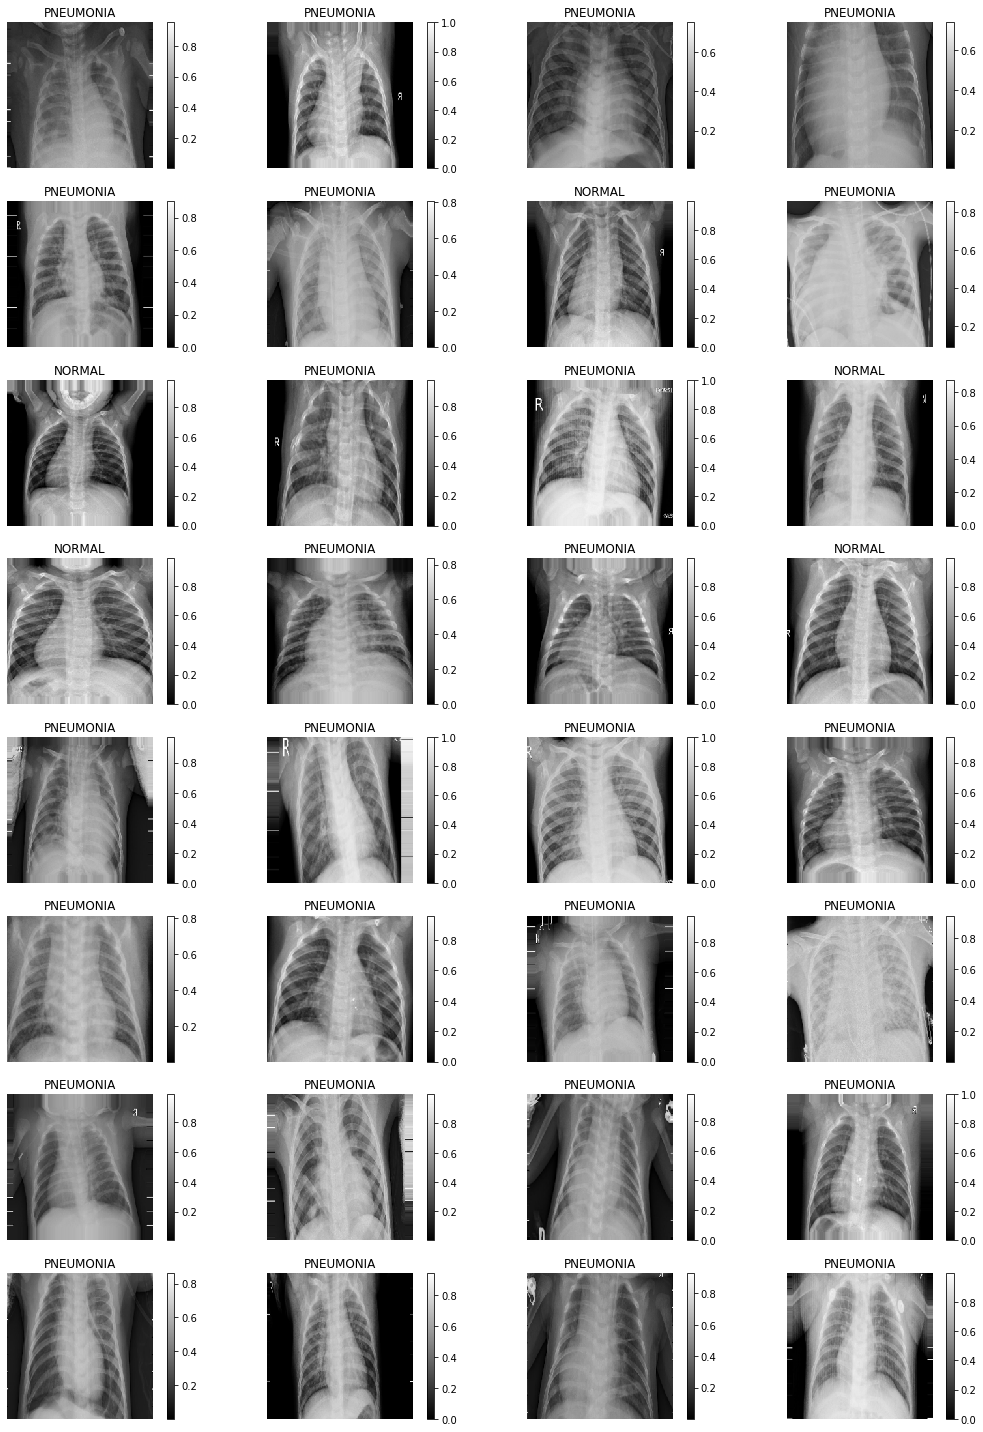

In [4]:
img, labels = train_generator.next()

plt.figure(figsize=(15,20))
for i in range(len(img)):
    label = 'NORMAL'
    if labels[i] == 1:
        label = 'PNEUMONIA'
    plt.subplot(8,4,i+1)
    plt.title(label)
    plt.imshow(img[i], cmap='gray')
    plt.axis('off')
    plt.colorbar()
plt.tight_layout()

Just at a first glance, the 'pneumonia' images appear to be a little fuzzier. The 'normal' images appear to have a more defined black area between the ribs. However, it's not something I would be comfortable trying to differentiate on my own, so let's try out some neural networks!

## Model

In [5]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report

In [6]:
# Adding some callbacks to avoid training for too long
def init_callbacks():
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss',
                                  verbose=1, save_best_only=True,
                                  save_weights_only=True)

    callbacks = [early_stopping, model_checkpoint]
    return callbacks

### Model 1

Let's start with a model with a single hidden layer. We'll use 128 nodes with 'relu' activation.

In [7]:
model_1 = Sequential()
model_1.add(Flatten(input_shape=(224,224,3)))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               19267712  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 19,267,841
Trainable params: 19,267,841
Non-trainable params: 0
_________________________________________________________________


In [8]:
history_1 = model_1.fit(train_generator,
                       epochs=25,
                       validation_data=val_generator,
                       callbacks=init_callbacks())

Epoch 1/25
163/163 [==============================] - 85s 518ms/step - loss: 10.2409 - accuracy: 0.7107 - val_loss: 1.1253 - val_accuracy: 0.6250

Epoch 00001: val_loss improved from inf to 1.12532, saving model to best_model.h5
Epoch 2/25
163/163 [==============================] - 83s 510ms/step - loss: 0.5110 - accuracy: 0.8483 - val_loss: 1.3954 - val_accuracy: 0.6250

Epoch 00002: val_loss did not improve from 1.12532
Epoch 3/25
163/163 [==============================] - 79s 484ms/step - loss: 0.7264 - accuracy: 0.8335 - val_loss: 0.4280 - val_accuracy: 0.8125

Epoch 00003: val_loss improved from 1.12532 to 0.42795, saving model to best_model.h5
Epoch 4/25
163/163 [==============================] - 79s 483ms/step - loss: 0.5145 - accuracy: 0.8560 - val_loss: 0.5614 - val_accuracy: 0.8125

Epoch 00004: val_loss did not improve from 0.42795
Epoch 5/25
163/163 [==============================] - 79s 484ms/step - loss: 0.4260 - accuracy: 0.8654 - val_loss: 0.4773 - val_accuracy: 0.8750


Because of our callbacks, the model stopped training early because the loss was not improving on the validation set.

Let's make a quick function to plot out the model's performance across epochs.

In [9]:
def plot_model(hist):
    '''
    input: fitted model
    output: plots of accuracy and loss
    '''
    x = range(1,len(hist.history['loss'])+1)
    fig,ax = plt.subplots(2,1,figsize=(12,8))
    ax[0].plot(x, hist.history['accuracy'], label='acc')
    ax[0].plot(x, hist.history['val_accuracy'], label='val acc')
    ax[0].legend()
    ax[0].set_title('Accuracy')
    ax[1].plot(x, hist.history['loss'], label='loss')
    ax[1].plot(x, hist.history['val_loss'], label='val loss')
    ax[1].legend()
    ax[1].set_title('Loss')
    plt.show()

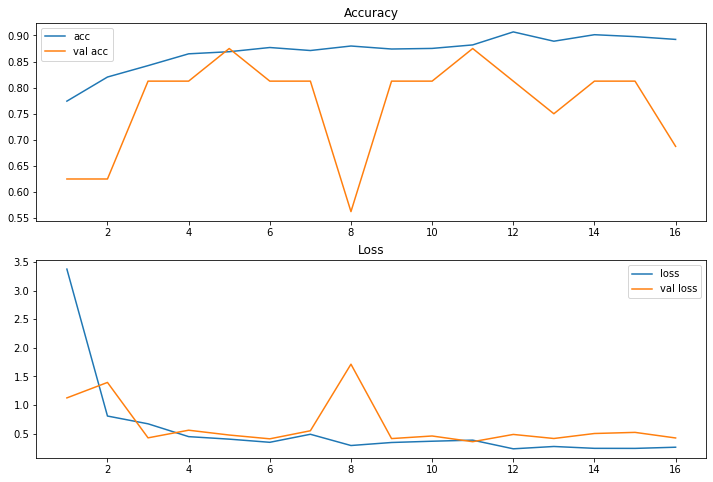

In [10]:
plot_model(history_1)

Those lines really started diverging quickly. Let's load up the best weights and check our performance on the test set.

In [11]:
model_1.save_weights('last_model.h5')
model_1.evaluate(test_generator)

20/20 [==============================] - 4s 205ms/step - loss: 0.3286 - accuracy: 0.8526


[0.32862070202827454, 0.8525640964508057]

In [12]:
model_1.load_weights('best_model.h5')
model_1.evaluate(test_generator)

20/20 [==============================] - 4s 202ms/step - loss: 0.3138 - accuracy: 0.8590


[0.3138106167316437, 0.8589743375778198]

In [13]:
predictions = model_1.predict(test_generator)
y_pred = (predictions > 0.5).astype('int')

y_true = test_generator.classes

In [14]:
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.77      0.80       234
           1       0.87      0.91      0.89       390

    accuracy                           0.86       624
   macro avg       0.85      0.84      0.85       624
weighted avg       0.86      0.86      0.86       624

[[181  53]
 [ 35 355]]


Our base model gets us 86% accuracy with a 91% recall on positive cases. This is a good start. Let's see if we can improve our model.

### Model 2 - Deeper

For the next model, we'll try going a little deeper with three hidden layers.

In [15]:
model_2 = Sequential()
model_2.add(Flatten(input_shape=(224,224,3)))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                9633856   
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 9,642,241
Trainable params: 9,642,241
Non-trainable params: 0
_________________________________________________________________


In [16]:
history_2 = model_2.fit(train_generator,
                        epochs=25,
                        validation_data=val_generator,
                        callbacks=init_callbacks())

Epoch 1/25
163/163 [==============================] - 76s 466ms/step - loss: 3.8824 - accuracy: 0.6885 - val_loss: 0.9281 - val_accuracy: 0.6250

Epoch 00001: val_loss improved from inf to 0.92809, saving model to best_model.h5
Epoch 2/25
163/163 [==============================] - 76s 468ms/step - loss: 0.3942 - accuracy: 0.8427 - val_loss: 0.4331 - val_accuracy: 0.8750

Epoch 00002: val_loss improved from 0.92809 to 0.43315, saving model to best_model.h5
Epoch 3/25
163/163 [==============================] - 77s 470ms/step - loss: 0.3546 - accuracy: 0.8508 - val_loss: 0.4934 - val_accuracy: 0.8125

Epoch 00003: val_loss did not improve from 0.43315
Epoch 4/25
163/163 [==============================] - 77s 472ms/step - loss: 0.3205 - accuracy: 0.8655 - val_loss: 0.7093 - val_accuracy: 0.6250

Epoch 00004: val_loss did not improve from 0.43315
Epoch 5/25
163/163 [==============================] - 77s 470ms/step - loss: 0.2888 - accuracy: 0.8773 - val_loss: 0.6411 - val_accuracy: 0.6875



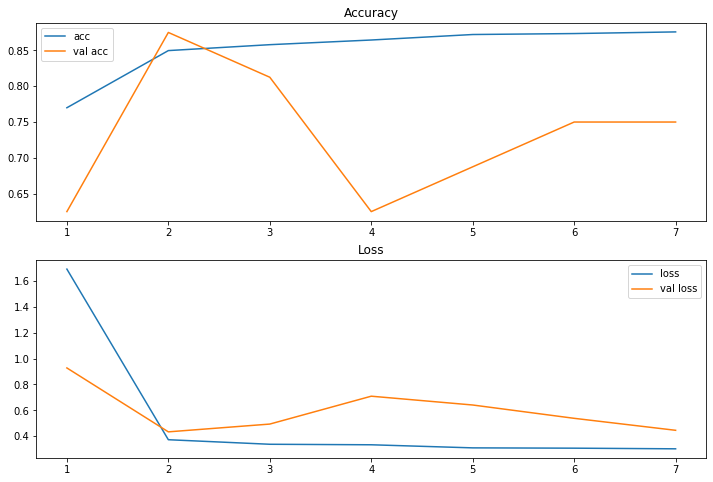

In [17]:
plot_model(history_2)

In [18]:
model_2.save_weights('last_model.h5')
model_2.evaluate(test_generator)

20/20 [==============================] - 4s 201ms/step - loss: 0.3249 - accuracy: 0.8542


[0.32494595646858215, 0.8541666865348816]

In [19]:
model_2.load_weights('best_model.h5')
model_2.evaluate(test_generator)

20/20 [==============================] - 4s 200ms/step - loss: 0.3420 - accuracy: 0.8413


[0.3419956564903259, 0.8413461446762085]

In [20]:
y_pred = model_2.predict(test_generator)
y_pred = (y_pred > 0.5).astype('int32')

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78       234
           1       0.85      0.90      0.88       390

    accuracy                           0.84       624
   macro avg       0.84      0.82      0.83       624
weighted avg       0.84      0.84      0.84       624

[[174  60]
 [ 39 351]]


### Model 3 - Convolutional Neural Network
Convolutional neural networks have a reputation for being effective at image classification, so let's see if we can use the power of CNNs to improve our performance.

In [21]:
model_3 = Sequential()
model_3.add(Conv2D(128, kernel_size=3, activation='relu',
                   input_shape=(224,224,3)))
model_3.add(Conv2D(64, kernel_size=3, activation='relu'))
model_3.add(Conv2D(32, kernel_size=3, activation='relu'))
model_3.add(Flatten())
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 128)     3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 218, 218, 32)      18464     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1520768)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1520769   
Total params: 1,616,609
Trainable params: 1,616,609
Non-trainable params: 0
_________________________________________________________________


Convolutional Neural Networks take much more time to train, so I'm going to train this one in Google Colab and then load the weights after it's completed.

In [22]:
model_3 = tf.keras.models.load_model('cnn/content/cnn')

In [23]:
model_3.evaluate(test_generator)

20/20 [==============================] - 19s 907ms/step - loss: 0.5595 - accuracy: 0.7804


[0.5594589710235596, 0.7804487347602844]

In [24]:
y_pred = model_3.predict(test_generator)
y_pred = (y_pred > 0.5).astype('int')

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred, normalize='true'))

              precision    recall  f1-score   support

           0       0.90      0.47      0.61       234
           1       0.75      0.97      0.85       390

    accuracy                           0.78       624
   macro avg       0.83      0.72      0.73       624
weighted avg       0.81      0.78      0.76       624

[[0.46581197 0.53418803]
 [0.03076923 0.96923077]]


### Model 4 - More Complex CNN
This model will add MaxPooling2D layers for downsampling and Dropout layers to help reduce overfitting.

In [25]:
model_4 = Sequential()
model_4.add(Conv2D(32, kernel_size=(3,3), activation='relu',
                   input_shape=(224,224,3)))
model_4.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Dropout(0.25))
model_4.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model_4.add(MaxPooling2D())
model_4.add(Dropout(0.25))
model_4.add(Flatten())
model_4.add(Dense(64, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 108, 108, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 128)      

With 23.9 million trainable parameters, we're going to train this one in Colab again.

In [26]:
model_4 = tf.keras.models.load_model('cnn2/content/cnn2')

In [27]:
model_4.evaluate(test_generator)

20/20 [==============================] - 10s 491ms/step - loss: 0.5111 - accuracy: 0.8157


[0.5110576152801514, 0.8157051205635071]

In [28]:
y_pred = model_4.predict(test_generator)
y_pred = (y_pred > 0.5).astype('int32')

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred, normalize='true'))

              precision    recall  f1-score   support

           0       0.98      0.52      0.68       234
           1       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.88      0.76      0.78       624
weighted avg       0.85      0.82      0.80       624

[[0.52136752 0.47863248]
 [0.00769231 0.99230769]]


This model achieves 99% recall with 82% accuracy. It's not our most accurate model, but I think the boost in recall makes up for it. With our model identifying 99% of patients with pneumonia, a few false positives is an acceptable compromise.

## iNterpret

Let's quickly compare our models.

In [29]:
def get_preds(model):
    '''returns a models predictions for the test set'''
    y_pred = model.predict(test_generator)
    y_pred = (y_pred > 0.5).astype('int')
    return y_pred

In [30]:
models = [model_1, model_2, model_3, model_4]
for i in range(4):
    print(f'Model {i+1}:')
    y_pred = get_preds(models[i])
    print(classification_report(y_true, y_pred))
    print()
    print(confusion_matrix(y_true, y_pred))
    print()    

Model 1:
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       234
           1       0.87      0.91      0.89       390

    accuracy                           0.86       624
   macro avg       0.85      0.84      0.85       624
weighted avg       0.86      0.86      0.86       624


[[181  53]
 [ 35 355]]

Model 2:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       234
           1       0.85      0.90      0.88       390

    accuracy                           0.84       624
   macro avg       0.84      0.82      0.83       624
weighted avg       0.84      0.84      0.84       624


[[174  60]
 [ 39 351]]

Model 3:
              precision    recall  f1-score   support

           0       0.90      0.47      0.61       234
           1       0.75      0.97      0.85       390

    accuracy                           0.78       624
   macro avg       0.83      0.72      0.73       6

With class support of 234 negative to 390 positive, we would be getting ~50% accuracy with random guesses and ~60% accuracy with all-majority-class predictions. So every model has learned something and shows improved performance over random guessing.

With the problem at hand, we want a model that shows high recall on positive cases (predictions identify positive cases) and high precision on negative cases (negative predictions are true). We got a big jump on those metrics when we moved to the convolutional neural network, although the overall accuracy did take a bit of a hit. However, with our more complex CNN, we were able to improve accuracy to 82% with 99% positive recall and 98% negative precision.

# Conclusion

We were able to get good results using Convolutional Neural Networks. While the accuracy was a bit lower than that of the more traditional neural networks, it did improve the positive recall significantly.

## Recommendations

If pursuing this topic to further improve results, I would make the following recommendations.

1. More Data - The dataset used here is only a portion of a larger dataset. While the larger dataset does not necessarily guarantee better performance, more data will help to reduce overfitting because of increased variance in the training data. A larger dataset should also give a statistically stronger representation of real-world implementation.

2. Pretrained Models - There are a number of pretrained models out there which may be effective for this problem. Many of them are included with Keras. We did not explore any of those models in this notebook, but some research into those models may find some that improve performance without the work of constructing your own models.

3. Address Class Imbalance - When constructing these models, I did not address the issue of class imbalance. While I think the results are satisfactory, addressing the issue of class imbalance early (perhaps by constructing a custom loss function) might improve performance.

## Future Work

Given more time with this data, I'd like to explore some of the popular CNN architectures. Whether or not they improve performance, I would like to get a look into the structure of these models to get a better idea of how convolutional neural networks accomplish their tasks.